<a name="polyp-segmentation:-data-exploration-and-dataset-preperation"></a>
# Polyp Segmentation: Data Exploration and Dataset Preperation

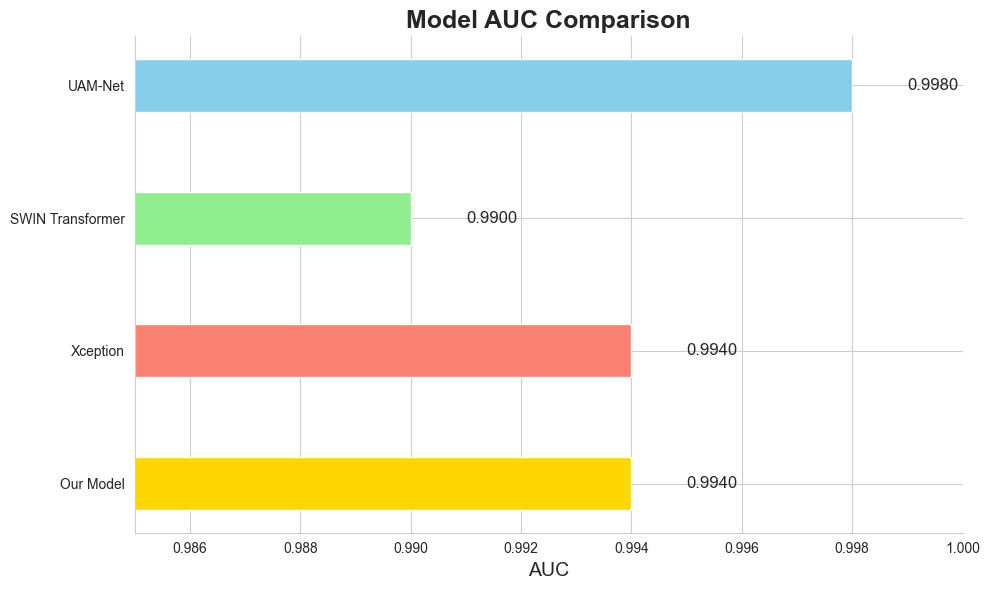

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply a professional Seaborn style
sns.set_style("whitegrid")

# Model names and their corresponding scores (reversed order)
models = ['Our Model', 'Xception', 'SWIN Transformer', 'UAM-Net']
scores = [0.9940, 0.994, 0.9900, 0.998]

# Bar colors
colors = ['#FFD700', '#FA8072', '#90EE90', '#87CEEB']  # gold, salmon, light green, sky blue

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(models, scores, color=colors, height=0.4)

# Annotate scores on bars
for bar, score in zip(bars, scores):
    plt.text(score + 0.001, bar.get_y() + bar.get_height()/2,
             f'{score:.4f}', va='center', fontsize=12)

# Title and labels
plt.title('Model AUC Comparison', fontsize=18, weight='bold')
plt.xlabel('AUC', fontsize=14)
plt.xlim(0.985, 1.0)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


In [1]:
# File processing
import os
from glob import glob
import json
from PIL import Image
from tqdm import tqdm

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Image processing
import cv2

In [2]:
data_dir = "./Kvasir-SEG"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

images_files = os.listdir(images_dir)
masks_files = os.listdir(masks_dir)

images_formats = set()
for file_name in os.listdir(images_dir):
    file_path = os.path.join(images_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        images_formats.add(file_format)

masks_formats = set()
for file_name in os.listdir(masks_dir):
    file_path = os.path.join(masks_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        masks_formats.add(file_format)

print(f"There are {len(images_files)} colonoscopic images with {images_formats} format")
print(f"There are {len(masks_files)} segmentation masked images with {masks_formats} format")

There are 1000 colonoscopic images with {'jpg'} format
There are 1001 segmentation masked images with {'jpg'} format


In [3]:
images_files[:5]

['colonoscopy_0001.jpg',
 'colonoscopy_0002.jpg',
 'colonoscopy_0003.jpg',
 'colonoscopy_0004.jpg',
 'colonoscopy_0005.jpg']

In [4]:
masks_files[:5]

['mask_0001.jpg',
 'mask_0002.jpg',
 'mask_0003.jpg',
 'mask_0004.jpg',
 'mask_0005.jpg']

The original file names for both images and masks are the same, this will cause confussion in the future. Let's rename them.

In [5]:
# Define a dictionary to map the original filenames to new filenames
name_mapping = {"images": "colonoscopy_", "masks": "mask_"}

# Rename the files in the "images" subdirectory
for i, file_name in enumerate(images_files):
    old_file_path = os.path.join(images_dir, file_name)
    new_file_name = f"{name_mapping['images']}{i+1:04d}.jpg"
    new_file_path = os.path.join(images_dir, new_file_name)
    os.rename(old_file_path, new_file_path)

# Rename the files in the "masks" subdirectory
for i, file_name in enumerate(masks_files):
    old_file_path = os.path.join(masks_dir, file_name)
    new_file_name = f"{name_mapping['masks']}{i+1:04d}.jpg"
    new_file_path = os.path.join(masks_dir, new_file_name)
    os.rename(old_file_path, new_file_path)

Here's the renamed colonoscopic images

In [6]:
# Renamed image file name
images_files = os.listdir(images_dir)
images_files[:5]

['colonoscopy_0001.jpg',
 'colonoscopy_0002.jpg',
 'colonoscopy_0003.jpg',
 'colonoscopy_0004.jpg',
 'colonoscopy_0005.jpg']

Here's the renamed masked images

In [7]:
# Renamed image file name
masks_files = os.listdir(masks_dir)
masks_files[:5]

['mask_0001.jpg',
 'mask_0002.jpg',
 'mask_0003.jpg',
 'mask_0004.jpg',
 'mask_0005.jpg']

New JSON file with renamed file names

In [8]:
# Define the path to the "kavsir_bboxes.json" file
data_dir = "./Kvasir-SEG"
file_path = os.path.join(data_dir, "kavsir_bboxes.json")

# Check if the JSON file exists
if os.path.exists(file_path):
    # Read the JSON file
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    # Create a new dictionary to store the renamed data
    renamed_data = {}

    # Rename the serial numbers in the JSON file
    for i, (file_name, file_data) in enumerate(data.items(), start=1):
        new_file_name = f"colonoscopy_{i:04d}"
        renamed_data[new_file_name] = file_data

    # Save the renamed data to a new JSON file
    renamed_file_path = os.path.join(data_dir, "renamed_bboxes.json")
    with open(renamed_file_path, 'w') as json_file:
        json.dump(renamed_data, json_file, indent=4)

    print(f"The JSON file has been renamed and saved to {renamed_file_path}")
else:
    # Print a message indicating that the file does not exist
    print(f"The JSON file {file_path} does not exist")

The JSON file ./Kvasir-SEG\kavsir_bboxes.json does not exist


In [9]:
# Define the path to the "renamed_bboxes.jso" file
data_dir = "./Kvasir-SEG"
file_path = os.path.join(data_dir, "renamed_bboxes.json")

# Read the JSON file
with open(file_path, 'r') as json_file:
    json_object = json.load(json_file)

# Print first 5 serials
list(json_object.keys())[:5]

['colonoscopy_0001',
 'colonoscopy_0002',
 'colonoscopy_0003',
 'colonoscopy_0004',
 'colonoscopy_0005']

<a name="remove-duplicated-file"></a>


<a name="set-path-to-accessing-the-data"></a>
### Set path to accessing the data

Path to the images, masks, and the JSON file

In [10]:
# Define the path to the "Kvasir-SEG" directory, "images" and "masks" subdirectories, and the JSON file
data_dir = "./Kvasir-SEG"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")
images_json= os.path.join(data_dir, "renamed_bboxes.json")

# Get a list of filenames in the "images" and "masks" subdirectories
images_files = os.listdir(images_dir)
masks_files = os.listdir(masks_dir)

# Read the JSON file
with open(images_json, 'r') as json_file:
    kavsir_bboxes = json.load(json_file)

In [11]:
# Print the number of images and masks
print(f"There are {len(images_files)} colonoscopic images")
print(f"There are {len(masks_files)} segmentation masked images")
print(f"The JSON file contains the mask coordinates for the {len(list(kavsir_bboxes))} colonoscopic images ")

There are 1000 colonoscopic images
There are 1001 segmentation masked images
The JSON file contains the mask coordinates for the 1000 colonoscopic images 


Note we have limited of just 1000 images, we can generate more samples using data augmentation to make our model more robust

Image data

In [12]:
# Read first image from RGB colonoscopic images
cv2.imread(os.path.join(images_dir,images_files[0]))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

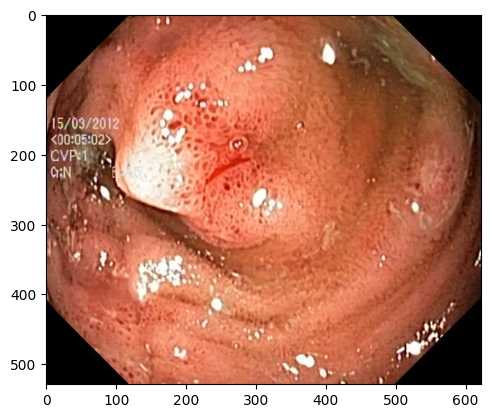

In [13]:
# Read image (BGR by default)
BGR_img1 = cv2.imread(os.path.join(images_dir,images_files[0]))

# Convert BGR to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(RGB_img1)
plt.show()

In [14]:
# Check shape of image
RGB_img1.shape

(529, 622, 3)

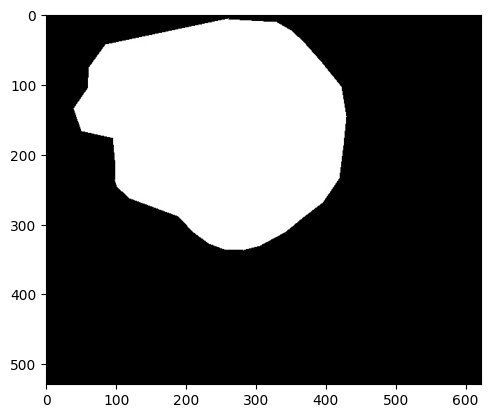

In [15]:
# Read first image from mask images
mask_img1 = cv2.imread(os.path.join(masks_dir,masks_files[0]))

# Display image
plt.imshow(mask_img1)
plt.show()

In [16]:
# Check shape of image
mask_img1.shape

(529, 622, 3)

In [17]:
#Find out the min and max values of pixels in the RGB image
print('RGB Image:')
print('Image minimum value: ',RGB_img1.min())
print('Image maximum value: ',RGB_img1.max())

#Find out the min and max values of pixels in the mask image
print('Mask Image:')
print('Image minimum value: ',mask_img1.min())
print('Image maximum value: ',mask_img1.max())

RGB Image:
Image minimum value:  0
Image maximum value:  255
Mask Image:
Image minimum value:  0
Image maximum value:  255


### Checking image width and height

In [18]:
# Empty list to store Booleans of whether or not the size of images and masks are equal
bool_size = []

for image_file, mask_file in zip(images_files, masks_files):
    image_path = os.path.join(images_dir, image_file)
    mask_path = os.path.join(masks_dir, mask_file)

    # Open the image and mask files
    with Image.open(image_path) as image, Image.open(mask_path) as mask:
        # Get the dimensions of the image and mask
        image_size = image.size
        mask_size = mask.size

        # Compare the dimensions
        if image_size == mask_size:
            bool_size.append(True)
        else:
            bool_size.append(False)

print(f"{all(bool_size)}, both images and masks have the same size.")

True, both images and masks have the same size.


In [19]:
heights = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[0] for idx in range(len(images_files))]
widths = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[1] for idx in range(len(images_files))]

Now, let's see how the widths and heights are distributed

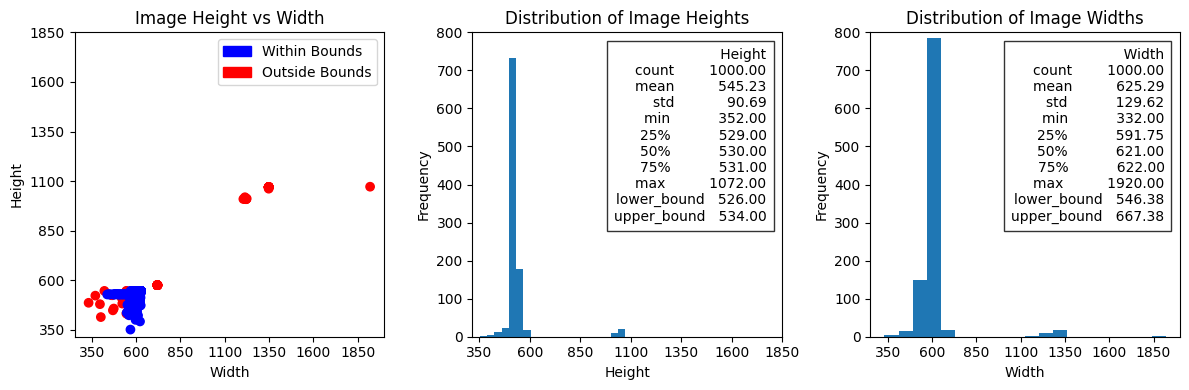

In [20]:
import matplotlib.patches as mpatches

df = pd.DataFrame({'Height': heights, 'Width': widths})

# Generate the summary statistics
summary = round(df.describe(), 2)

# Calculate the lower bound and upper bound
q1 = summary.loc['25%']
q3 = summary.loc['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Add the lower bound and upper bound to the summary
summary.loc['lower_bound'] = round(lower_bound,2)
summary.loc['upper_bound'] = round(upper_bound,2)

# Create a figure with two subplots and a scatter plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the scatter plot of heights and widths
colors = np.where((heights >= lower_bound['Height']) & (heights <= upper_bound['Height']) |
                  (widths >= lower_bound['Width']) & (widths <= upper_bound['Width']), 'blue', 'red')

scatter = axs[0].scatter(widths, heights, c=colors)
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')
axs[0].set_title('Image Height vs Width')
axs[0].set_xticks(np.arange(350, 1920, 250))
axs[0].set_yticks(np.arange(350, 1920, 250))

# Create legend labels
legend_labels = [mpatches.Patch(color='blue', label='Within Bounds'),
                 mpatches.Patch(color='red', label='Outside Bounds')]

# Add legend
axs[0].legend(handles=legend_labels)

# Plot the histogram of heights
axs[1].hist(heights, bins=20)
axs[1].set_xlabel('Height')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Image Heights')
axs[1].set_xticks(np.arange(350, 1920, 250))
axs[1].text(0.95, 0.95, str(summary[['Height']]), transform=axs[1].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Plot the histogram of widths
axs[2].hist(widths, bins=20)
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Image Widths')
axs[2].text(0.95, 0.95,
            str(summary[['Width']]),
            transform=axs[2].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
axs[2].set_xticks(np.arange(350, 1920, 250))

# Set the same vertical scale for both histograms
axs[1].set_ylim([0, 800])
axs[2].set_ylim([0, 800])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


<a name="check-polyp-positions"></a>
### Check polyp positions

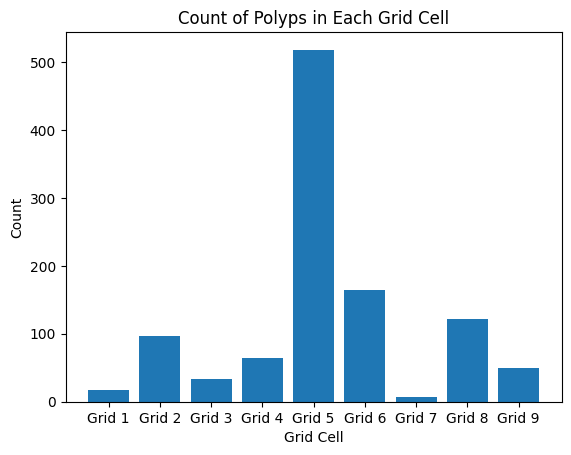

In [21]:
# Initialize a 3x3 grid to store the grid counts
grid_counts = [[0] * 3 for _ in range(3)]

# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the center coordinates
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2

        # Determine the grid cell based on the center coordinates
        grid_row = int(y_center / (height / 3))
        grid_col = int(x_center / (width / 3))

        # Increment the count for the corresponding grid cell
        grid_counts[grid_row][grid_col] += 1

# Flatten the grid counts into a 1D list
counts = [count for row in grid_counts for count in row]

# Define the labels for the grid cells
labels = ['Grid {}'.format(i+1) for i in range(9)]

# Create a bar chart
x_pos = np.arange(len(labels))
plt.bar(x_pos, counts, align='center')

# Set the axis labels and title
plt.xlabel('Grid Cell')
plt.ylabel('Count')
plt.title('Count of Polyps in Each Grid Cell')

# Set the x-axis tick labels
plt.xticks(x_pos, labels)

# Display the plot
plt.show()

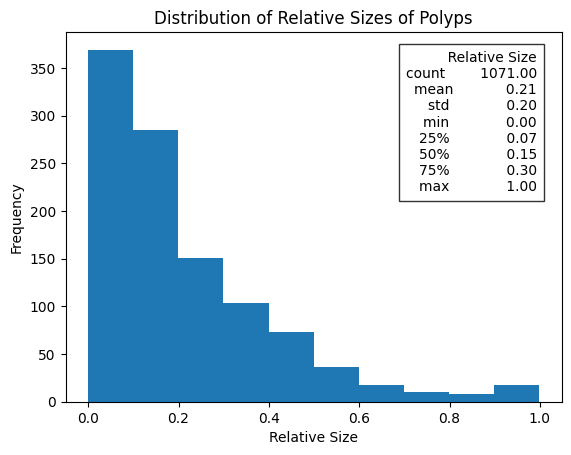

In [22]:
# Empty list to store all the relative sizes
relative_sizes = []

# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the width and height of the bounding box
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin

        # Calculate the area of the bounding box
        bbox_area = bbox_width * bbox_height

        # Calculate the area of the image
        image_area = height * width

        # Calculate the relative size of the bounding box
        relative_size = bbox_area / image_area

        # Append the relative size to the list
        relative_sizes.append(relative_size)

# Calculate the summary statistics
summary = pd.DataFrame({'Relative Size': relative_sizes}).describe().round(2)

# Plot the histogram of relative sizes
n, bins, patches = plt.hist(relative_sizes)
plt.xlabel('Relative Size')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Sizes of Polyps')

# Add the summary statistics to the plot as text annotations
summary_text = str(summary[['Relative Size']])
plt.text(0.95, 0.95,
         summary_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Display the plot
plt.show()

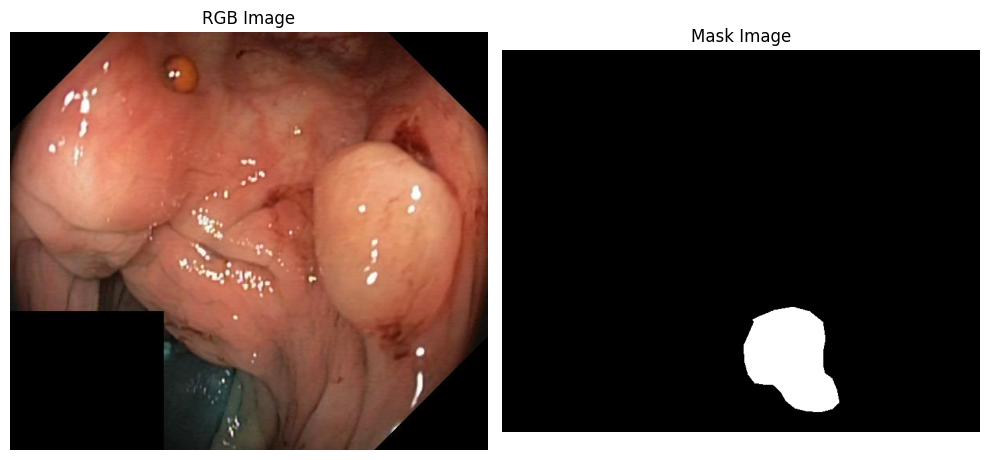

In [23]:
# Load RGB image and mask
image_path = os.path.join(images_dir, images_files[-7])
mask_path = os.path.join(masks_dir, masks_files[-7])
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB Image')
axs[0].axis('off')

# Plot the mask image
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask Image')
axs[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 295.47it/s]


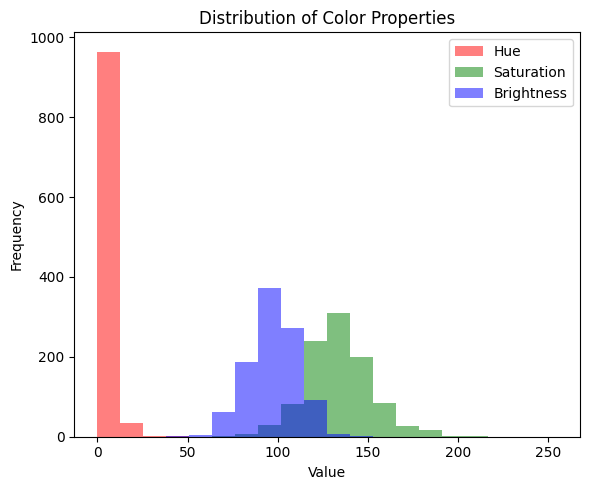

,Hue,Saturation,Brightness
count,1000.00,1000.00,1000.00
mean,9.03,134.14,97.48
std,2.40,18.28,13.46
min,4.28,75.41,48.13
25%,7.82,122.69,88.91
50%,8.65,133.69,97.60
75%,9.71,144.66,106.68
max,48.53,206.39,151.25
skewness,6.69,0.29,-0.23


In [24]:
# Calculate the average brightness, hue, and saturation of the images
brightness_values = []
hue_values = []
saturation_values = []

# Create a progress bar for the loop
for image_file in tqdm(images_files):
    # Load the image
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)

    # Convert the image to different color spaces
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the average pixel intensities
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    brightness_values.append(brightness)

    # Calculate the average hue value
    hue = np.mean(hsv_image[:, :, 0])
    hue_values.append(hue)

    # Calculate the average saturation value
    saturation = np.mean(hsv_image[:, :, 1])
    saturation_values.append(saturation)

# Set the same range for the x-axis
x_axis_range = (0, 255)  # Adjust this range as per your requirement

# Display the histograms of hue, saturation, and brightness values
plt.figure(figsize=(6, 5))
n, bins, patches = plt.hist(hue_values, bins=20, range=x_axis_range, color='r', alpha=0.5, label='Hue')
plt.hist(saturation_values, bins=20, range=x_axis_range, color='g', alpha=0.5, label='Saturation')
plt.hist(brightness_values, bins=20, range=x_axis_range, color='b', alpha=0.5, label='Brightness')

# Set the labels, title, and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Color Properties')
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Create a DataFrame with hue, saturation, and brightness values
df = pd.DataFrame({'Hue': hue_values, 'Saturation': saturation_values, 'Brightness': brightness_values})

# Generate the summary statistics including skewness
summary = round(df.describe(), 2)
summary.loc['skewness'] = round(df.skew(), 2)

# Display the statistics
display(summary)
